# UnmuteAI Platform

The aim of the platform is to develop an application that can be used to predict the sentiment of a perceived review using a content-based filtering algorithm and sentiment analysis combined. The resulting engine is a sentiment-based recommender engine that outputs list of recommended games having closer sentiment values with the prediction probability of the trained classifiers. Unmuteai will take reviews and classify it as either positive sentiment or negative sentiment and also return list of recommended games. 

The fields of Natural Language Processing and Machine learning (including Deep learning) scope are put to test for the development of this unmuteai. The dataset used are scraped contents from Metascritc website containing game reviews and other game features from critics. Adequate request has been made towards acquiring permissions for retrieving the content from the website using both Request and BeautifulSoup API (Python libraries). The dataset contains 8671 rows and 8 columns. Some other columns are featured extracted using already present once. 

The Dataset has no missing values, the reason being that some checking procedures where implemented when web scraping the data. Necessary Data cleaning using modules and utilities provided by the NLTK and TextBlob Libraries are performed on the the dataset. The normalisation with regards to removal of HTML tags have been done in the web scraping process. About 5 models are fitted on the cleaned and preporcessed dataset. All models outperformed the benchmarked accuracy score except the the model created using custom word embeddings.  

In [ ]:
!pip install nltk

In [ ]:
nltk.download()

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import utils
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import contractions as ct
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import Word, TextBlob
import string
import re
import os

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tunde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading Game Review dataset from the system 

## Data Loading and Initial exploration 

In [5]:
print(os.getcwd())
game_reviews = os.getcwd() + "\data\game_reviews.csv"
print(game_reviews)

# Loading Data
df = pd.read_csv(game_reviews)

# Performing initial exploration
# Data shape
print(df.shape)

# Display the top 2 observations
print(df.head(2))

# Display the bottom 2 observations
print(df.tail(2))

# The column names are prefixed with whitespace, this need to be removed
df.columns = df.columns.str.strip()

# Normalizing the column names (change all to uppercase)
df.columns = df.columns.str.upper()

# showing the attributes in the dataset
print(df.columns)

# Checking for any missing values in the columns
print(df.isnull().sum())

# Learning more anout the dataset
print(df.describe())

# Estimating the mean metascore 
mean_score = df["METASCORE"].mean()
print("The mean score of metascore : {0:.2f}".format(mean_score))

# Unique games in the dataset
unique_games = np.unique(df["TITLE"])
print(len(unique_games))

# Unique platforms in the dataset
unique_platform = np.unique(df["PLATFORM"])
print("The list of platforms contained in the dataset: {}".format(len(unique_platform)))


C:\Users\tunde\Documents\GitHub\unmuteai
C:\Users\tunde\Documents\GitHub\unmuteai\data\game_reviews.csv
(8671, 8)
                                 title     platform   release_date   \
0  The Legend of Zelda: Ocarina of Time  Nintendo 64    Nov-23-1998   
1              Tony Hawk's Pro Skater 2  PlayStation    Sep-20-2000   

                developer                                genres   \
0                 Nintendo            Action Adventure | Fantasy   
1  Neversoft Entertainment  Sports | Alternative | Skateboarding   

         reviewer    metascore   \
0      Gaming Maxx          100   
1  CNET Gamecenter          100   

                                              review  
0  Nothing but pure 100% fun challenging and leng...  
1  The best skateboarding game ever and one of th...  
                                         title   platform   release_date   \
8669  Skylar & Plux: Adventure on Clover Island         PC    May-19-2017   
8670                                 In Be

## Data Preparation and Cleaning

- *Removing numeric values*
- *Removing punctuations*
- *performing contractions (dealing text inflections)*
- *Normalizing the text: includes transforming text into lowercase, removing tags if found, filter only alphanumeric features*
- *Transforming words into their base shape*
- *Removing stop words*

The following approach has been taken to categorize the metascore scheme definitions and categorization given by metacritic using their weighted average algorithm.

**<center>In the dataset, this is labled as pos: target - pos and UI: assigned a green color</center>**

| indications | metascore | label |
| :-: | :-: | :-: |
| Universal acclaim    | 90–100 | pos |
| Generally favorable reviews with some mixed positive oriented reviews    | 66–89 | pos |

       

**<center>In the dataset, this is labled as pos: target - neg and UI: assigned a red color</center>**

| indications | metascore | label
| :-: | :-: | :-: |
| Generally unfavorable reviews with some mixed negative oriented reviews   | 20–65 | neg |
| Overwhelming dislike    | 0–19 | neg |
           

In [6]:
stemmer = PorterStemmer()
words = stopwords.words("english")
punctuations = string.punctuation

## Processing utilities

# removes inflection: I'll ->I will  He'd -> He had
def remove_contractions(text):
    return ct.fix(text)

# transform words into their base or root form: giving -> give, having -> have, discussion -> discuss, lengthy -> lengthi
def get_stemmed_text(word):
    #word = word.lower()
    #root = stemmer.stem(word)
    #return str(TextBlob(root).correct())
    return stemmer.stem(word)
# hide '-' from the list of puctuations available in the string.puctuation module
def reset_punct():
    holder = string.punctuation
    return re.sub("\''","",holder)

def get_cleaned_review(item):
    #punctuations = reset_punct()
    fixed_text = remove_contractions(item)
    processed_text = [i.lower() for i in re.split(r"\W+", fixed_text)]
    processed_text = [ i for i in processed_text if not i in punctuations]
    processed_text = [ i for i in processed_text if len(i) > 2 ] 
    processed_text = [ i for i in processed_text if i.isalpha()]
    processed_text = [ get_stemmed_text(i) for i in processed_text if not i in words]
    return processed_text
# Deprecated
def metascore_to_label_depr(metascore):
    if metascore > 74:
        return 2
    elif metascore > 49 and metascore < 75:
        return 1
    else:
        return 0

# Label encoding 
def metascore_to_label(metascore):
    if metascore > 65:
        return 1
    else:
        return 0

# Split release date by the delimiter '-': from creating a new column 'RELEASE_YEAR'    
def get_release_year(release_year):
    return release_year.split("-")[2]



In [7]:
# Feature engineering: creating a new column off the REVIEW column 

df['PROCESSED_REVIEW'] = df['REVIEW'].apply(lambda row: " ".join(get_cleaned_review(row)))

df['RELEASE_YEAR'] = df['RELEASE_DATE'].apply(get_release_year)

df['TOKENIZED_REVIEW'] = df['PROCESSED_REVIEW'].apply(lambda row: [token for token in word_tokenize(row)])

df["LABEL"] = df.METASCORE.apply(lambda metascore: metascore_to_label(metascore))

df['REVIEW_WORD_COUNT'] = df['TOKENIZED_REVIEW'].apply(len)

df['SENTIMENT'] = df['PROCESSED_REVIEW'].apply(lambda review: TextBlob(review).sentiment.polarity)

df['SUBJECTIVITY'] = df['PROCESSED_REVIEW'].apply(lambda review: TextBlob(review).sentiment.subjectivity)


In [9]:
# Processed dataset
df.columns


Index(['TITLE', 'PLATFORM', 'RELEASE_DATE', 'DEVELOPER', 'GENRES', 'REVIEWER',
       'METASCORE', 'REVIEW', 'PROCESSED_REVIEW', 'RELEASE_YEAR',
       'TOKENIZED_REVIEW', 'LABEL', 'REVIEW_WORD_COUNT', 'SENTIMENT',
       'SUBJECTIVITY'],
      dtype='object')

In [10]:
df[:10]

,TITLE,PLATFORM,RELEASE_DATE,DEVELOPER,GENRES,REVIEWER,METASCORE,REVIEW,PROCESSED_REVIEW,RELEASE_YEAR,TOKENIZED_REVIEW,LABEL,REVIEW_WORD_COUNT,SENTIMENT,SUBJECTIVITY
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,Nov-23-1998,Nintendo,Action Adventure | Fantasy,Gaming Maxx,100,Nothing but pure 100% fun challenging and leng...,noth pure fun challeng lengthi,1998,"[noth, pure, fun, challeng, lengthi]",1,5,0.257143,0.350000
1,Tony Hawk's Pro Skater 2,PlayStation,Sep-20-2000,Neversoft Entertainment,Sports | Alternative | Skateboarding,CNET Gamecenter,100,The best skateboarding game ever and one of th...,best skateboard game ever one greatest playsta...,2000,"[best, skateboard, game, ever, one, greatest, ...",1,9,0.300000,0.525000
2,Grand Theft Auto IV,PlayStation 3,Apr-29-2008,Rockstar North,Action Adventure | Modern | Modern | Open-World,Jolt Online Gaming UK,100,Grand Theft Auto IV is not a perfect game but ...,grand theft auto perfect game fantast start fi...,2008,"[grand, theft, auto, perfect, game, fantast, s...",1,24,0.157143,0.600000
3,SoulCalibur,Dreamcast,Sep-8-1999,Namco,Action | Fighting | 3D,CheckOut,100,I guarantee you'll be amazed at how phenomenal...,guarante amaz phenomen game look abl put,1999,"[guarante, amaz, phenomen, game, look, abl, put]",1,7,-0.400000,0.400000
4,Grand Theft Auto IV,Xbox 360,Apr-29-2008,Rockstar North,Action Adventure | Modern | Modern | Open-World,Official Xbox Magazine UK,100,It's got a world you believe in a cast you car...,got world believ cast care script stuf brillia...,2008,"[got, world, believ, cast, care, script, stuf,...",1,14,0.900000,1.000000
5,Super Mario Galaxy,Wii,Nov-12-2007,Nintendo,Action | Platformer | Platformer | 3D | 3D,NTSC-uk,100,Mario has not grown older but younger with tim...,mario grown older younger time slender suppl g...,2007,"[mario, grown, older, younger, time, slender, ...",1,42,0.211111,0.406173
6,Super Mario Galaxy 2,Wii,May-23-2010,Nintendo EAD Tokyo,Action | Platformer | Platformer | 3D | 3D,Gamereactor Sweden,100,Improves on the first game and charms every bo...,improv first game charm everi bone game love b...,2010,"[improv, first, game, charm, everi, bone, game...",1,18,0.081250,0.429167
7,Red Dead Redemption 2,Xbox One,Oct-26-2018,Rockstar Games,Action Adventure | Open-World,GamingTrend,100,Red Dead Redemption 2 raises the bar for sandb...,red dead redempt rais bar sandbox adventur gam...,2018,"[red, dead, redempt, rais, bar, sandbox, adven...",1,27,-0.150000,0.300000
8,Grand Theft Auto V,Xbox One,Nov-18-2014,Rockstar North,Action Adventure | Modern | Open-World,X-ONE Magazine UK,100,It’s just a great game tying to be even better...,great game tie even better case work case ulti...,2014,"[great, game, tie, even, better, case, work, c...",1,23,0.366667,0.541667
9,Grand Theft Auto V,PlayStation 3,Sep-17-2013,Rockstar North,Modern | Action Adventure | Modern | Open-World,LEVEL (Czech Republic),100,GTA V fulfills the idea of a gaming sandbox wh...,gta fulfil idea game sandbox entertain mani di...,2013,"[gta, fulfil, idea, game, sandbox, entertain, ...",1,18,-0.400000,0.400000


In [24]:
df.groupby("LABEL").describe()

METASCORE                                                        \
          count       mean        std   min   25%   50%    75%    max   
LABEL                                                                   
0        4088.0  44.602495  11.949050   0.0  35.0  42.0   55.0   65.0   
1        4583.0  91.838316   8.215549  66.0  85.0  92.0  100.0  100.0   

      REVIEW_WORD_COUNT             ... SENTIMENT      SUBJECTIVITY            \
                  count       mean  ...       75%  max        count      mean   
LABEL                               ...                                         
0                4088.0  17.303327  ...  0.100000  1.0       4088.0  0.400286   
1                4583.0  19.677286  ...  0.237083  1.0       4583.0  0.419219   

                                                         
            std  min       25%       50%       75%  max  
LABEL                                                    
0      0.202824  0.0  0.300000  0.400000  0.510541  1.0  
1      0.191955  0.0  0.328646  0.415385  0.525466  1.0  

[2 rows x 32 columns]

In [11]:
## saving the processed dataframe as a binary file using pickle
# The content could be retrieved later from backup using pd.read_pickle(binary)
#df.to_pickle("processed_data.pickle")
df.to_csv(".\data\processed_data.csv")

## Exploratory Data Analysis (EDA)

[Text(0.5, 0, 'most common words'),
 Text(0, 0.5, '# occurences'),
 Text(0.5, 1.0, 'Plot of the most common words...')]

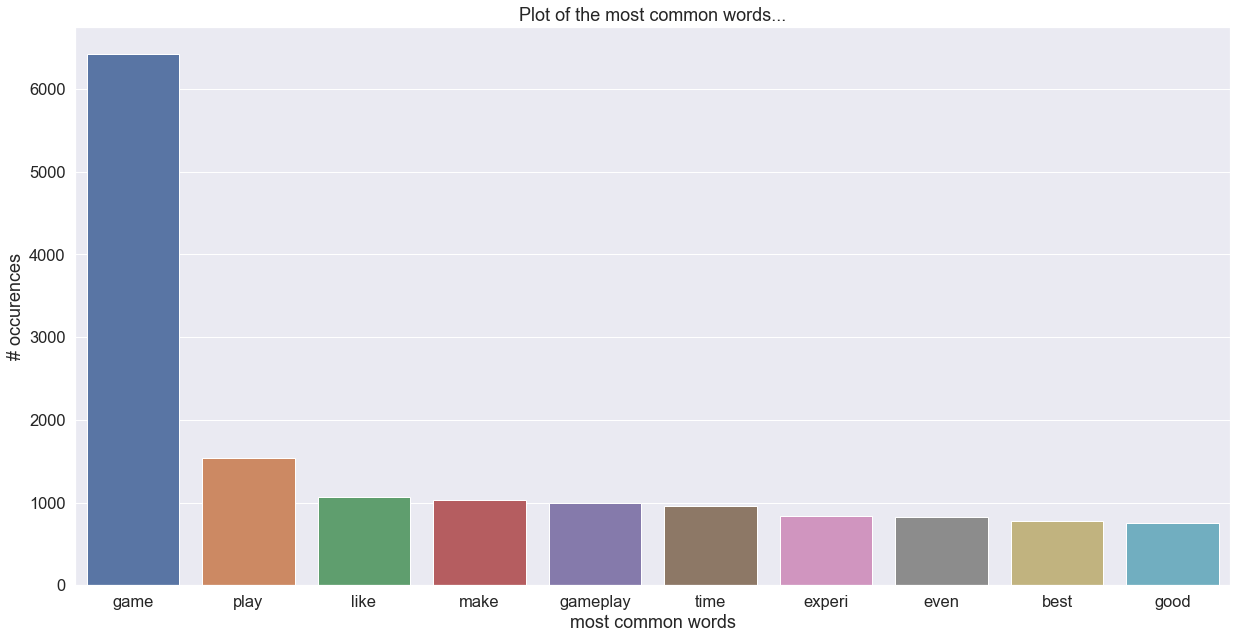

In [17]:
from nltk import FreqDist
import seaborn as sns
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize':(20.7,10.27)})
freq_dist_pos = FreqDist(X for i in df.TOKENIZED_REVIEW for X in i if len(X) > 3) 
most_common = freq_dist_pos.most_common(10)
most_common_df_ = pd.DataFrame(most_common, columns = ["WORD","COUNT"])
plot = sns.barplot(x='WORD',y="COUNT", data=most_common_df_)
plot.set(xlabel="most common words", ylabel = "# occurences", title = "Plot of the most common words...")

In [13]:
# Most common words
most_common_df_

,WORD,COUNT
0,game,6428
1,play,1539
2,like,1072
3,make,1030
4,gameplay,995
5,time,959
6,experi,842
7,even,821
8,best,773
9,good,748


<AxesSubplot:>

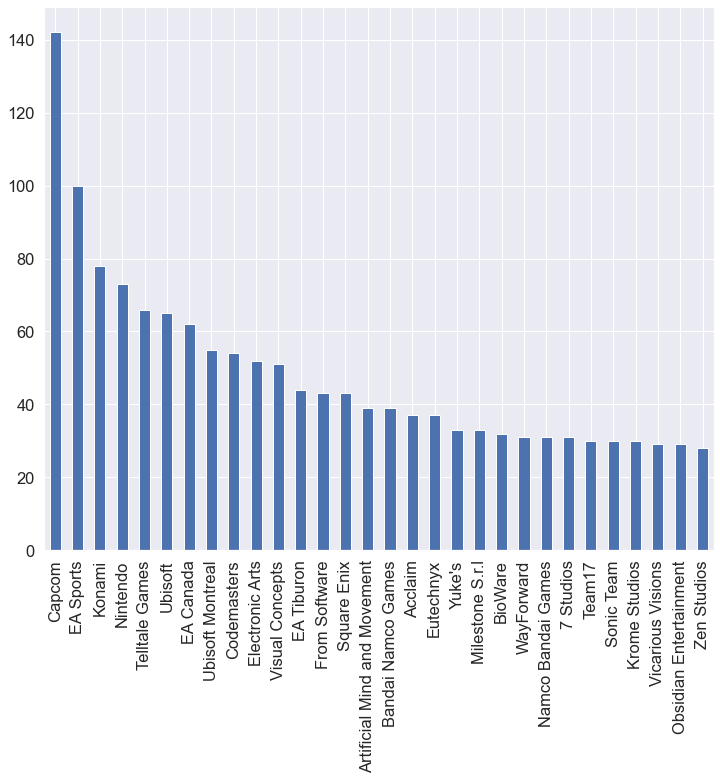

In [14]:
df['DEVELOPER'].value_counts().head(30).plot(kind='bar', figsize=(12,10))

[Text(0, 0.5, '# games released'),
 Text(0.5, 1.0, 'Plot of game releases by year')]

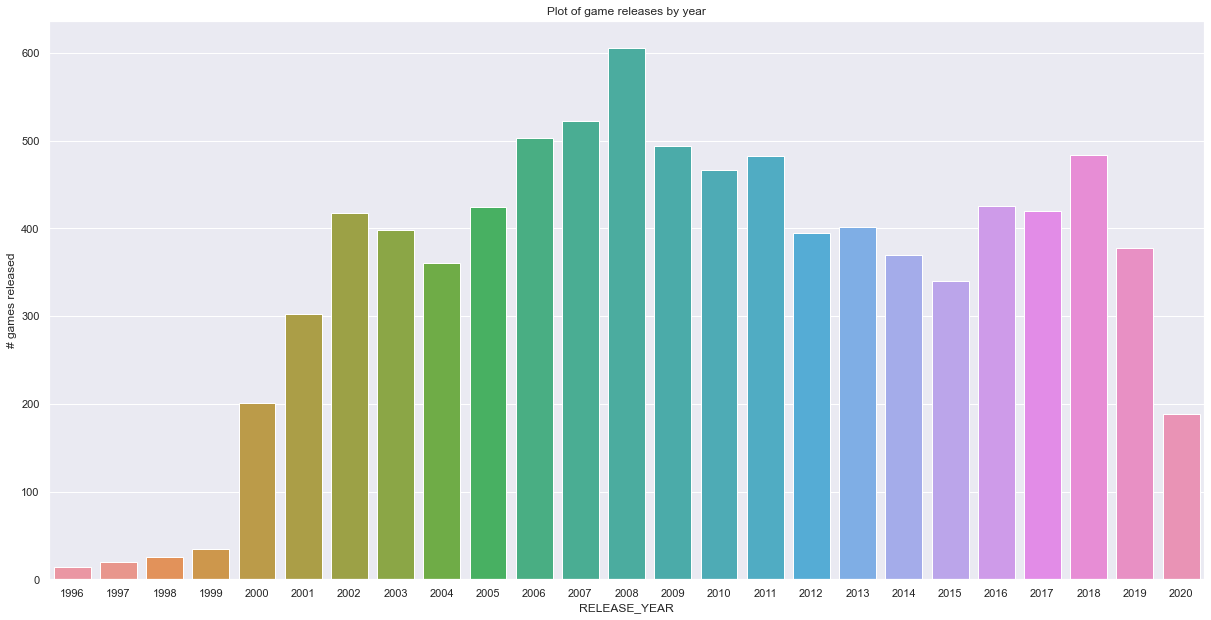

In [27]:
# Plot showing the game releases by year.
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize':(20.7,10.27),"axes.titlesize":19,"axes.labelsize":19})
plot = sns.countplot(x='RELEASE_YEAR', data=df)
plot.set(ylabel="# games released", title = "Plot of game releases by year")

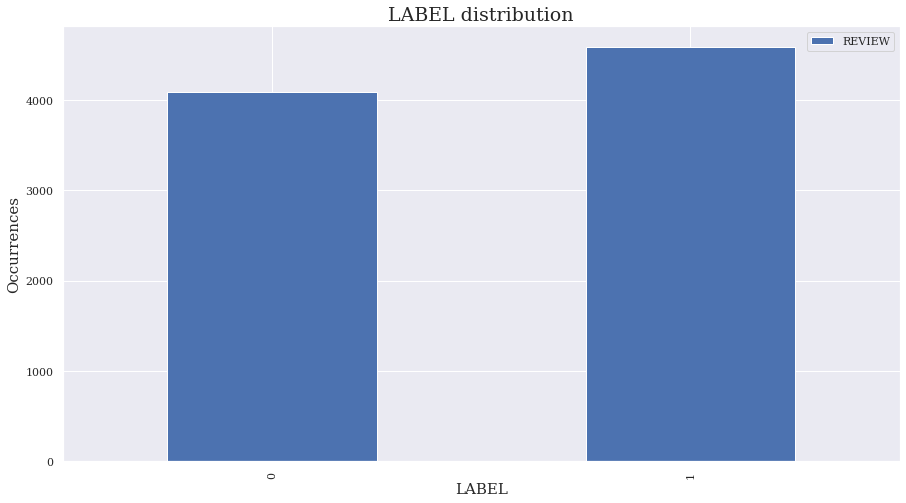

In [65]:
#df.filter(["REVIEW", "METASCORE", "RELEASE_YEAR"])
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)
df.groupby('LABEL').REVIEW.count().plot.bar(figsize=(15, 8))
plt.title("LABEL distribution")
plt.ylabel('Occurrences', fontsize=15)
plt.xlabel('LABEL', fontsize=15)
plt.legend()
plt.show()

[Text(0, 0.5, '# games'),
 Text(0.5, 1.0, 'Plot of game compatibility with platforms.')]

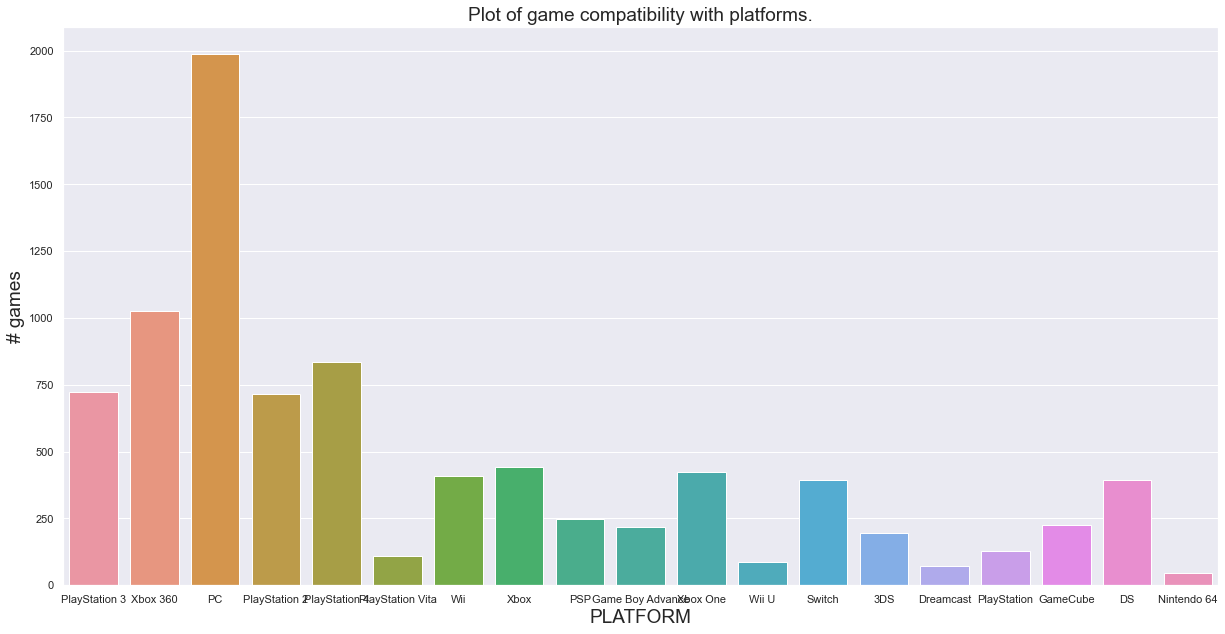

In [66]:
# Plot showing the most used platforms
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize':(20.7,10.27),"axes.titlesize":19,"axes.labelsize":19})
plot = sns.countplot(x='PLATFORM', data=df)
plot.set(ylabel="# games", title = "Plot of game compatibility with platforms.")

## Baseline | Benchmark Accuracy

In [34]:
## displaying the number of observations with negative sentiment in the dataset.
print("Negative Label: {}".format((df["LABEL"] == 0).sum()))

## displaying the number of observations with positive sentiment in the dataset.
print("Positive Label: {}".format((df["LABEL"] == 1).sum()))

## The baseline accuracy
## this the ratio of the majority class (pos label) to the size of the dataset.
## This would be used as a benchmark when evaluating the minimum accuracy for the models
print("Benchmark Accuracy: {:.2f}".format((df["LABEL"] == 1).sum()/len(df)))

Negative Label: 4088
Positive Label: 4583
Benchmark Accuracy: 0.53


## Training and Testing Set

In [98]:
df = utils.shuffle(df)
# isolating the target column (label)
y = df['LABEL']

X = df.drop(['LABEL'], axis=1)

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Displaying the shape of the features and target section of the dataset
# shape of train set
print(X_train.shape)
print(y_train.shape)

# Shape of test set
print(X_test.shape)
print(y_test.shape)


(6936, 14)
(6936,)
(1735, 14)
(1735,)


In [38]:
# proportion 0 and 1 in both train and test set
print("***** feature split *****")
print((y_test == 0).sum())
print((y_test == 1).sum())
print('\n')
print("***** target split ******")
print((y_train == 0).sum())
print((y_train == 1).sum())

***** feature split *****
830
905


***** target split ******
3258
3678


## Developing models and Fitting them on the Extracted features

#### 1. Fitting the Naive Bayes model on the training set and perform performance evaluation on it 

{'nb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


              precision    recall  f1-score   support

           0      0.908     0.782     0.840       830
           1      0.823     0.927     0.872       905

    accuracy                          0.858      1735
   macro avg      0.865     0.854     0.856      1735
weighted avg      0.863     0.858     0.857      1735



Accuracy Score: 0.86


Confusion matrix Score: [[839  66]
 [181 649]]

f1 Score 0.87

AUC Score 0.89



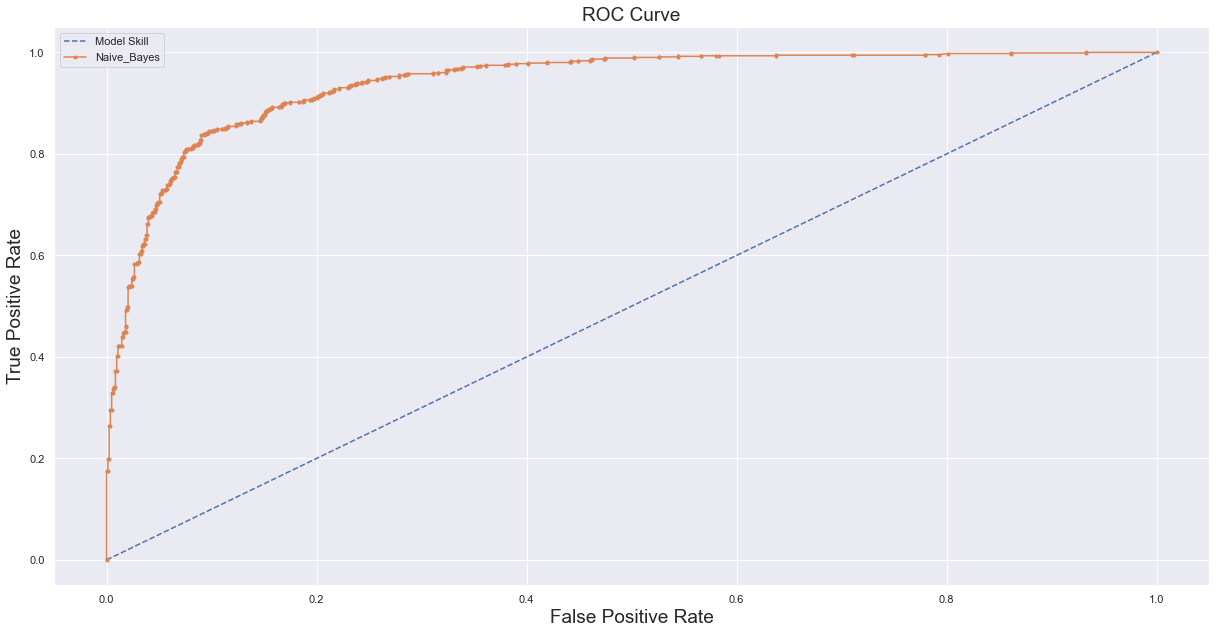

[1 0 0 0 0 1 1 1 1 1]
[0 0 0 0 0 1 1 1 1 1]


In [74]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,roc_curve,roc_auc_score,f1_score,auc,precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer

pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('nb', MultinomialNB())])
parameters_ = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'nb__alpha': [1, 1e-1, 1e-2]
}

#cls_naivebayes_ = MultinomialNB()
nb_clf = GridSearchCV(pipeline, param_grid=parameters_, cv=5)
nb_clf.fit(X_train["PROCESSED_REVIEW"].values, y_train)

print(nb_clf.best_params_);print('\n')
y_pred = nb_clf.predict(X_test["PROCESSED_REVIEW"].values)
# predict probabilities
clf_probs = nb_clf.predict_proba(X_test["PROCESSED_REVIEW"].values)

## Perforamnce metrics
print(classification_report(y_test, y_pred, digits=3));print('\n')
print('Accuracy Score: {:.2f}\n\n'.format(accuracy_score(y_test, y_pred)))
print('Confusion matrix Score: {}\n'.format(confusion_matrix(y_test, y_pred, labels=[1,0])))

# Filtering out the Negative actual ovservations
ns_probs = [0 for _ in range(len(y_test))]
# Positive prediction probabilities
# first index being the negative sentiment...
clf_probs = clf_probs[:, 1]
## calculating at each threshold both precision and recall
clf_precision, clf_recall, _ = precision_recall_curve(y_test, y_pred)

# calculate f1_score
clf_f1 = f1_score(y_test, y_pred)
# calculate auc score
clf_auc = auc(clf_recall, clf_precision)

print("f1 Score {:.2f}\n".format(clf_f1))
print("AUC Score {:.2f}\n".format(clf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, clf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive_Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
# show the legend
plt.legend()
# show the plot
plt.show()
print(y_pred[300:310])
print(y_test[300:310].values)

In [151]:
## Testing how good the model is...
X_pred = clf.predict(["best games"])
## Prediction
print(X_pred)

X_pred = clf.predict(["It is a lovely game but I had a really bad experience while playing it..."])
## Prediction
print(X_pred)

X_pred = clf.predict_proba(["best games"])
## Prediction
print(X_pred)

X_pred = clf.predict_proba(["It is a lovely game but I had a really bad experience while playing it..."])
## Prediction
print(X_pred)

[1]
[0]
[[0.15 0.85]]
[[1. 0.]]


### 2. Fitting RandomForestClassifier on the train set

{'clf__criterion': 'entropy', 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}


              precision    recall  f1-score   support

           0      0.785     0.749     0.767       830
           1      0.779     0.812     0.795       905

    accuracy                          0.782      1735
   macro avg      0.782     0.781     0.781      1735
weighted avg      0.782     0.782     0.782      1735



Accuracy Score: 0.78


Confusion matrix Score: [[735 170]
 [208 622]]

f1 Score 0.80

AUC Score 0.84



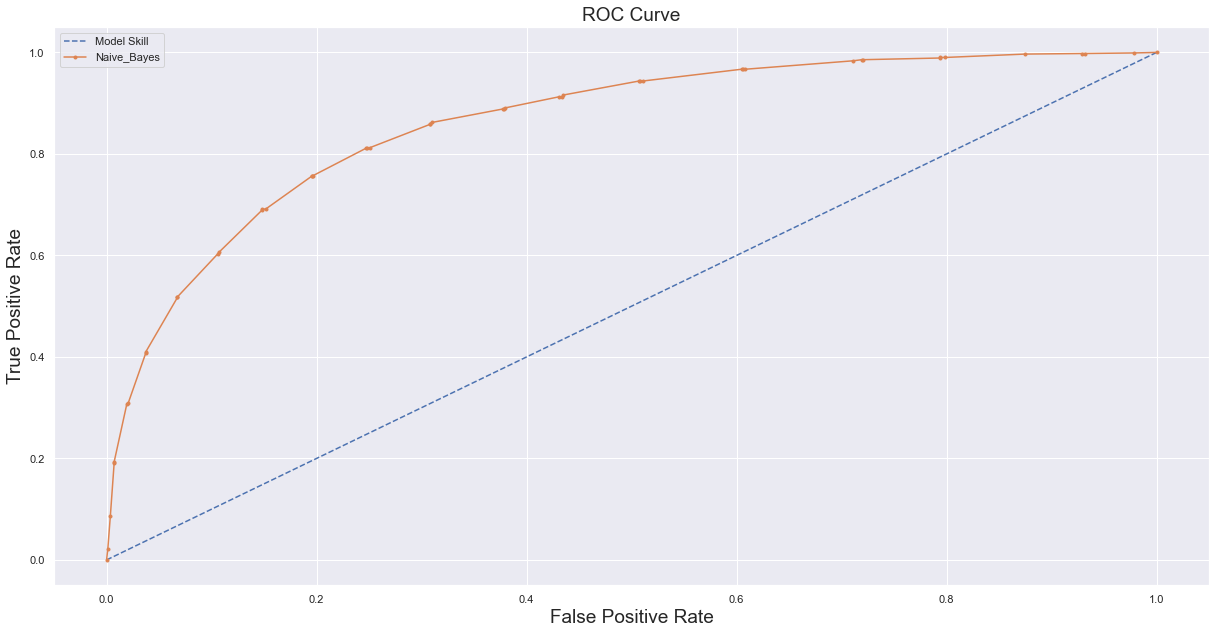

[1 0 0 0 0 1 1 1 0 0]
[0 0 0 0 0 1 1 1 1 1]


In [75]:
from sklearn.ensemble import RandomForestClassifier

#rf_classifier_ = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 100)
 #'clf__n_estimators': [20],
#'clf__max_features': ['auto', 'sqrt', 'log2'],
#'clf__max_depth' : [4,5,6,7,8]

pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators = 20,random_state = 200))])
parameters_ = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__criterion' :['gini', 'entropy']
}


rf_clf = GridSearchCV(pipeline, param_grid=parameters_, cv=5)
rf_clf.fit(X_train["PROCESSED_REVIEW"].values, y_train)

print(rf_clf.best_params_);print('\n')

y_pred = rf_clf.predict(X_test["PROCESSED_REVIEW"].values)
# predict probabilities
clf_probs = rf_clf.predict_proba(X_test["PROCESSED_REVIEW"].values)

## Perforamnce metrics
print(classification_report(y_test, y_pred, digits=3));print('\n')
print('Accuracy Score: {:.2f}\n\n'.format(accuracy_score(y_test, y_pred)))
print('Confusion matrix Score: {}\n'.format(confusion_matrix(y_test, y_pred, labels=[1,0])))

# Filtering out the Negative actual ovservations
ns_probs = [0 for _ in range(len(y_test))]
# Positive prediction probabilities
# first index being the negative sentiment...
clf_probs = clf_probs[:, 1]
## calculating at each threshold both precision and recall
clf_precision, clf_recall, _ = precision_recall_curve(y_test, y_pred)

# calculate f1_score
clf_f1 = f1_score(y_test, y_pred)
# calculate auc score
clf_auc = auc(clf_recall, clf_precision)

print("f1 Score {:.2f}\n".format(clf_f1))
print("AUC Score {:.2f}\n".format(clf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, clf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, marker='.', label='RandomForest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
# show the legend
plt.legend()
# show the plot
plt.show()

print(y_pred[300:310])
print(y_test[300:310].values)

### 3. Fitting SVM method (SVC) on the train set 

{'svc__C': 1, 'svc__kernel': 'linear', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


              precision    recall  f1-score   support

           0      0.860     0.814     0.837       830
           1      0.838     0.878     0.858       905

    accuracy                          0.848      1735
   macro avg      0.849     0.846     0.847      1735
weighted avg      0.848     0.848     0.848      1735



Accuracy Score: 0.85


Confusion matrix Score: [[795 110]
 [154 676]]

f1 Score 0.86

AUC Score 0.89



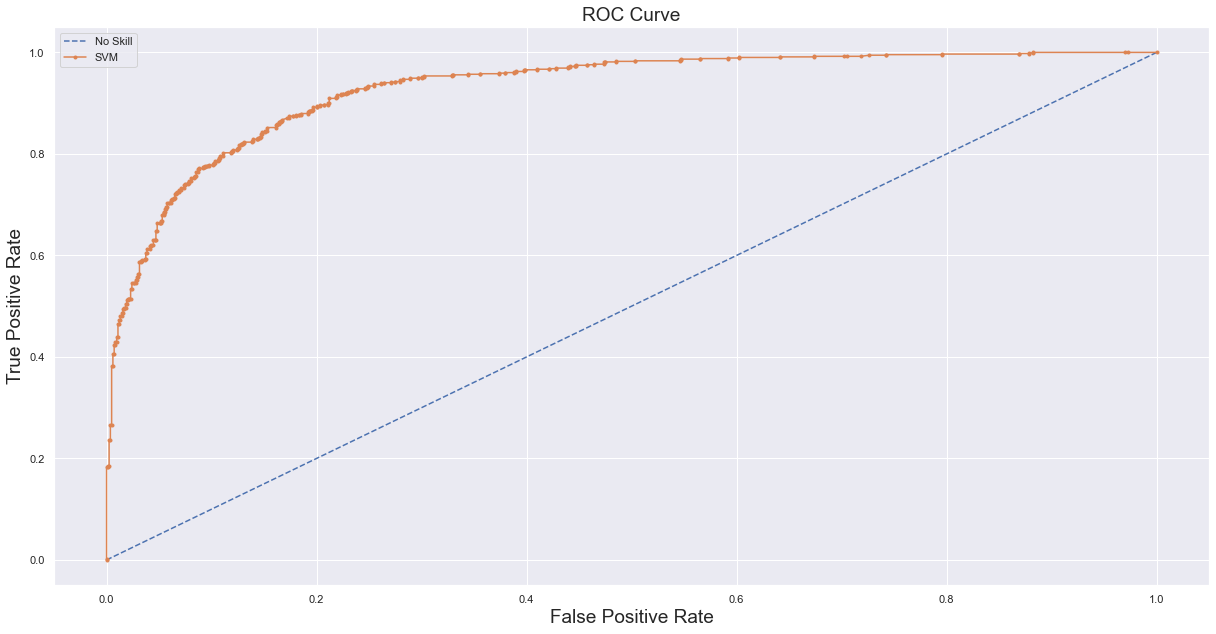

[1 0 0 0 0 1 1 1 1 1]
[0 0 0 0 0 1 1 1 1 1]


In [88]:
from sklearn import svm

parameters_ = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear']
}

pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('svc', svm.SVC(probability=True))])

svm_clf = GridSearchCV(pipeline, param_grid=parameters_, cv=5)
svm_clf.fit(X_train["PROCESSED_REVIEW"].values, y_train)
print(svm_clf.best_params_);print('\n')

y_pred = svm_clf.predict(X_test["PROCESSED_REVIEW"].values)

# predict probabilities
clf_probs = svm_clf.predict_proba(X_test["PROCESSED_REVIEW"].values)

## Perforamnce metrics
print(classification_report(y_test, y_pred, digits=3));print('\n')
print('Accuracy Score: {:.2f}\n\n'.format(accuracy_score(y_test, y_pred)))
print('Confusion matrix Score: {}\n'.format(confusion_matrix(y_test, y_pred, labels=[1,0])))

# Filtering out the Negative actual ovservations
ns_probs = [0 for _ in range(len(y_test))]
# Positive prediction probabilities
# first index being the negative sentiment...
clf_probs = clf_probs[:, 1]
## calculating at each threshold both precision and recall
clf_precision, clf_recall, _ = precision_recall_curve(y_test, y_pred)

# calculate f1_score
clf_f1 = f1_score(y_test, y_pred)
# calculate auc score
clf_auc = auc(clf_recall, clf_precision)

print("f1 Score {:.2f}\n".format(clf_f1))
print("AUC Score {:.2f}\n".format(clf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, clf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, marker='.', label='SVM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
# show the legend
plt.legend()
# show the plot
plt.show()

print(y_pred[300:310])
print(y_test[300:310].values)

### 4. Logistic regression

C:\Users\tunde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tunde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

{'lr__C': 10, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


              precision    recall  f1-score   support

           0      0.860     0.808     0.834       830
           1      0.834     0.880     0.856       905

    accuracy                          0.846      1735
   macro avg      0.847     0.844     0.845      1735
weighted avg      0.846     0.846     0.845      1735



Accuracy Score: 0.85


Confusion matrix Score: [[796 109]
 [159 671]]

f1 Score 0.86

AUC Score 0.89



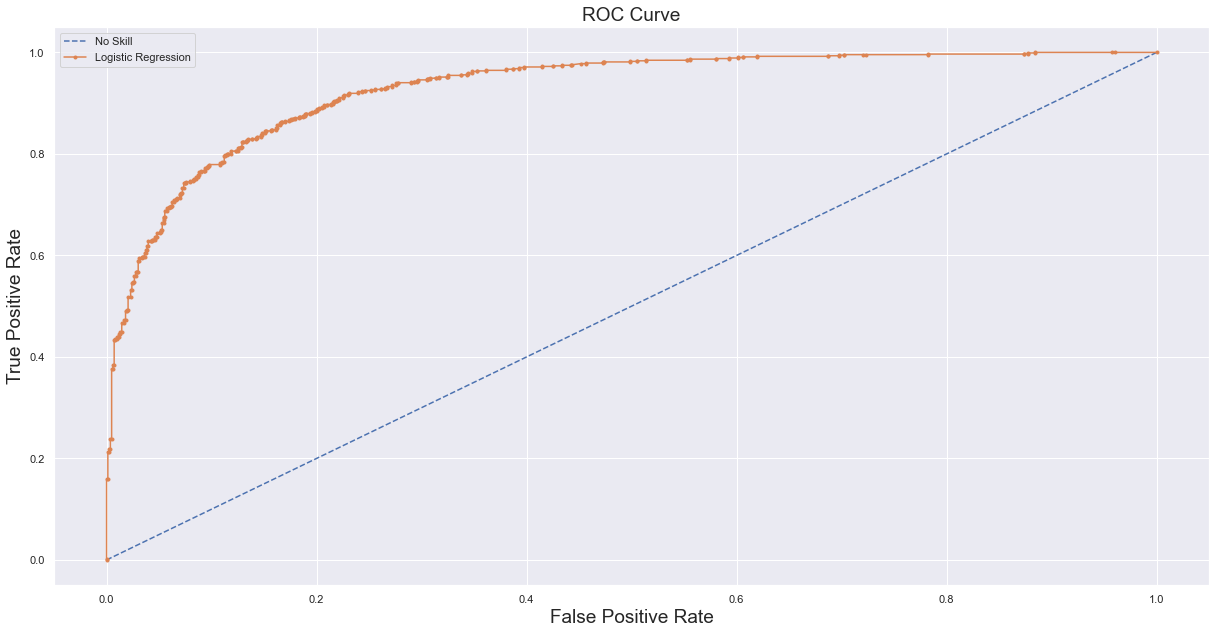

[1 0 0 0 0 1 1 1 1 0]
[0 0 0 0 0 1 1 1 1 1]


In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, roc_auc_score

parameters_ = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'lr__C': [0.1, 1, 10]
}

pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lr',  LogisticRegression())])

LR_clf = GridSearchCV(pipeline, param_grid=parameters_, cv=5)
LR_clf.fit(X_train["PROCESSED_REVIEW"].values, y_train)

print(LR_clf.best_params_);print('\n')
# Predict with the unseen set (testing set)
y_pred = LR_clf.predict(X_test["PROCESSED_REVIEW"].values)

# predict probabilities
clf_probs = LR_clf.predict_proba(X_test["PROCESSED_REVIEW"].values)

## Perforamnce metrics
print(classification_report(y_test, y_pred, digits=3));print('\n')
print('Accuracy Score: {:.2f}\n\n'.format(accuracy_score(y_test, y_pred)))
print('Confusion matrix Score: {}\n'.format(confusion_matrix(y_test, y_pred, labels=[1,0])))

# Filtering out the Negative actual ovservations
ns_probs = [0 for _ in range(len(y_test))]
# Positive prediction probabilities
# first index being the negative sentiment...
clf_probs = clf_probs[:, 1]
## calculating at each threshold both precision and recall
clf_precision, clf_recall, _ = precision_recall_curve(y_test, y_pred)

# calculate f1_score
clf_f1 = f1_score(y_test, y_pred)
# calculate auc score
clf_auc = auc(clf_recall, clf_precision)

print("f1 Score {:.2f}\n".format(clf_f1))
print("AUC Score {:.2f}\n".format(clf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, clf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, marker='.', label='Logistic Regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
# show the legend
plt.legend()
# show the plot
plt.show()

print(y_pred[300:310])
print(y_test[300:310].values)

### 5. Basic Neural Network Using Keras: Training word Embedding and fit NN on the word vector (word embedding)

In [ ]:
!pip install keras
!pip install theano
!pip install tensorflow

In [78]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [97]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
#encoder = LabelEncoder()
#encoded_dec = encoder.fit_transform(y) 
#one_hot_Y = to_categorical(encoded_dec)

y = df['LABEL'].values
# Encoding reviews: 80000 word-dimension
sequence_hash_size = 80000
encoded_features = [one_hot(review, sequence_hash_size) for review in df.PROCESSED_REVIEW.values]
#print(encoded_features)
# using 100 words as the max length (Indicating words with relatively close in meaning) for dense word vector
max_length = 200
padded_reviews = pad_sequences(encoded_features, maxlen=max_length, padding='post')

# instantiate the model
model = Sequential()
model.add(Embedding(sequence_hash_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                   
model.fit(padded_reviews, y,epochs=20, verbose=1)
print(model.summary())
loss, accuracy = model.evaluate(padded_reviews, y, verbose=0)
print('Accuracy: {:.2f}'.format(accuracy*100))


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 8)            640000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 1601      
Total params: 641,601
Trainable params: 641,601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
271/271 [==============================] - 3s 10ms/step - loss: 0.6819 - accuracy: 0.5699
Epoch 2/20
271/271 [==============================] - 3s 10ms/step - loss: 0.5180 - accuracy: 0.8020
Epoch 3/20
271/271 [==============================] - 3s 10ms/step - loss: 0.3347 - accuracy: 0.8857
Epoch 4/20
271/271 [==============================] - 3s 9ms/step - l

## Sentiment-Based Recommender Engine

In [80]:
#vectorizer_model = TfidfVectorizer(max_df=0.9)
#vectorizer_model.fit(X_train["PROCESSED_TEXT"].values)
#  displary vocabulary dictionary
#print(vectorizer_model.vocabulary_)
#print(vectorizer_model.idf_)

vectorizer_model = CountVectorizer()

# encode training set
vect_data = vectorizer_model.fit_transform(df["PROCESSED_REVIEW"].values)
print(list(vectorizer_model.vocabulary_)[:20])

#vect_test_data = vectorizer_model.transform(X_test["PROCESSED_REVIEW"].values)

# encoded vector
print(vect_data.shape)
print(vect_data.toarray())

#print(vect_test_data.shape)
#print(vect_test_data.toarray())

# first 50 features
print(vectorizer_model.get_feature_names()[:50])

['perfect', 'highli', 'recommend', 'titl', 'fp', 'fan', 'look', 'someth', 'fresh', 'bide', 'time', 'best', 'chang', 'interest', 'contradict', 'give', 'control', 'take', 'away', 'dust']
(8671, 10165)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['aaa', 'aback', 'abandon', 'abba', 'abbey', 'abbrevi', 'abc', 'abe', 'abhorr', 'abid', 'abil', 'abl', 'ablaz', 'aboard', 'abomin', 'abound', 'abras', 'abridg', 'abrupt', 'abruptli', 'absenc', 'absent', 'absolut', 'absolv', 'absorb', 'abstract', 'absurd', 'absurdist', 'absurdli', 'abund', 'abus', 'abysm', 'abyss', 'academi', 'academia', 'acc', 'accel', 'acceler', 'accent', 'accentu', 'accept', 'access', 'accessori', 'accid', 'accident', 'acclaim', 'acclim', 'accolad', 'accommod', 'accompani']


In [168]:
if type(similarity) == np.ndarray:
    print("here...")

here...


In [81]:
from sklearn.metrics.pairwise import cosine_similarity
import pickle
similarity = cosine_similarity(vect_data,vect_data)
print(similarity[1000:1020])

sim_scores =[]

def sortHelper(item):
    return item[3]

def Sorter(desc,obj):
     obj.sort(reverse=desc,key=sortHelper)

def get_recommended_games(title="",sim=similarity, rec_games=[], review_prob=1):
    #game_title = "*****" "Tony Hawk's Pro Skater 2"
    if title:
        sim_scores = df.loc[df["TITLE"] == title, ["TITLE"]]
        if len(sim_scores['TITLE'].values):
            
            sim_scores = sim_scores.index[0]
            sim_score = pd.Series(similarity[sim_scores])
            print(list(sim_score.sort_values(ascending= False))[:10])
            rec_games_index = sim_score.sort_values(ascending= False).index[:10]
            rec_games = [df.loc[df.index == game, ["TITLE","PLATFORM","RELEASE_DATE","SENTIMENT"]].values.flatten() for game in rec_games_index]
            Sorter(True,rec_games)
            with open('game_recommendation.data', 'wb') as fd:
                ## Storing binary stream using the file handler...
                pickle.dump(rec_games, fd)
            return rec_games_index,rec_games
        else:
            return "Game not found..."
    elif review_prob >= 0:
        sim_scores = df.loc[df["SENTIMENT"] >= (review_prob-0.5), ["SENTIMENT"]]
        if len(sim_scores['SENTIMENT'].values):
            sim_scores = sim_scores.index[0]
            sim_score = pd.Series(similarity[sim_scores])
            print(list(sim_score.sort_values(ascending= False))[:10])
            rec_games_index = sim_score.sort_values(ascending= False).index[:10]
            rec_games = [df.loc[df.index == game, ["TITLE","PLATFORM","RELEASE_DATE","SENTIMENT"]].values.flatten() for game in rec_games_index]
            Sorter(True,rec_games)
            with open('game_recommendation.data', 'wb') as fd:
                ## Storing binary stream using the file handler...
                pickle.dump(rec_games, fd)
            return rec_games_index,rec_games
        else:
            return "Games not found..."
    else:
        print("Game title not provided...")
get_recommended_games("The Guest",review_prob=1)

[[0.07106691 0.         0.14213381 ... 0.13074409 0.         0.14142136]
 [0.08703883 0.         0.08703883 ... 0.08006408 0.         0.05773503]
 [0.         0.         0.0836242  ... 0.15384615 0.         0.05547002]
 ...
 [0.         0.         0.         ... 0.10482848 0.         0.07559289]
 [0.         0.         0.14625448 ... 0.20180184 0.         0.14552138]
 [0.         0.08111071 0.         ... 0.         0.         0.        ]]
[0.9999999999999999, 0.2981423969999719, 0.282842712474619, 0.25819888974716115, 0.25819888974716115, 0.2480694691784169, 0.23904572186687872, 0.22360679774997896, 0.22360679774997896, 0.22360679774997896]


(Int64Index([8667, 7441, 7947, 2311, 2291, 7638, 2107, 7934, 1775, 4719], dtype='int64'),
 [array(['Roogoo: Twisted Towers', 'Wii', 'Jun-30-2009',
         0.22857142857142856], dtype=object),
  array(['Inner Chains', 'PC', 'May-18-2017', 0.09999999999999999],
        dtype=object),
  array(['Digimon World Data Squad', 'PlayStation 2', 'Sep-18-2007',
         0.08888888888888886], dtype=object),
  array(["Dr. Seuss' The Cat in the Hat", 'Game Boy Advance', 'Nov-5-2003',
         0.049999999999999996], dtype=object),
  array(['Dark Summit', 'PlayStation 2', 'Nov-26-2001',
         -0.08787878787878789], dtype=object),
  array(['Alone in the Dark', 'Wii', 'Jun-23-2008', -0.19], dtype=object),
  array(['Advent Rising', 'Xbox', 'May-31-2005', -0.2], dtype=object),
  array(['The Punisher', 'PC', 'Jan-18-2005', -0.29166666666666663],
        dtype=object),
  array(['The Guest', 'PC', 'Mar-10-2016', -0.4], dtype=object),
  array(['Pac-Man Party 3D', '3DS', 'Nov-8-2011', -0.4], dtype=object)])